In [83]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os

In [84]:
# CONSTANTS
FS = 104.0  # Sampling frequency in Hz
FS_SEC = 1.0 / FS  # Sampling period in seconds
FS_MSEC = FS_SEC * 1000.0  # Sampling period in milliseconds

DEG_TO_RAD = np.pi / 180.0  # Degrees to radians conversion factor
RAD_TO_DEG = 180.0 / np.pi  # Radians to degrees conversion factor
G_TO_MS2 = 9.80665  # Gravity to m/s^2 conversion factor
MG_TO_MS2 = G_TO_MS2 / 1000.0  # Milli-gravity to m/s^2 conversion factor

TAKE_OWN_TIMESTAMP = True


FILTERS = ["simple", "complementary", "madgwick", "mahony", "ukf"]


In [85]:
# Tests csv folder path
TESTS_CSV_PATH = "motion_detection_ideas/test_01/"
test_patterns = {
    "staticmethod": "*_static_*s.csv",
    "altitudemotionmethod": "*_move_*al_*s.csv",
    "azimuthmotionmethod": "*_move_*az_*s.csv",
    "vibrationmethod": "*_vibrations_*s.csv",
}

In [86]:
# Load dataset
datasets = {}
def wds_to_enu_transform():
    """
    Transformation matrix from WDS (West-Down-South) to ENU (East-North-Up)
    
    WDS: X-West, Y-Down, Z-South
    ENU: X-East, Y-North, Z-Up
    
    Transformation:
    ENU_X (East) = -WDS_X (opposite of West)
    ENU_Y (North) = -WDS_Z (opposite of South)  
    ENU_Z (Up) = -WDS_Y (opposite of Down)
    """
    # Transformation matrix WDS -> ENU
    T_wds_to_enu = np.array([
        [-1,  0,  0],  # East = -West
        [ 0,  0, -1],  # North = -South
        [ 0, -1,  0]   # Up = -Down
    ])
    return T_wds_to_enu

def validate_wds_transform(accel_wds):
    """
    Validate the WDS coordinate system assumption
    """
    print("=== WDS COORDINATE SYSTEM VALIDATION ===")
    
    # Check if we indeed have WDS orientation
    accel_enu, _ = transform_imu_data_wds_to_enu(accel_wds, accel_wds)
    
    # In ENU, gravity should point mostly in -Z direction
    gravity_wds = np.mean(accel_wds[:100], axis=0)  # Average first 100 samples
    gravity_enu = np.mean(accel_enu[:100], axis=0)
    
    print(f"Average acceleration in WDS frame: [{gravity_wds[0]:.1f}, {gravity_wds[1]:.1f}, {gravity_wds[2]:.1f}] m/s²")
    print(f"Average acceleration in ENU frame: [{gravity_enu[0]:.1f}, {gravity_enu[1]:.1f}, {gravity_enu[2]:.1f}] m/s²")
    print(f"Expected ENU gravity: [0, 0, 9.8] m/s²")
    
    # Check if transformation makes sense
    enu_magnitude = np.linalg.norm(gravity_enu)
    expected_up_component = gravity_enu[2]  # Should be ~9.8
    
    print(f"ENU gravity magnitude: {enu_magnitude:.2f} m/s² (expected ~9.8)")
    print(f"ENU up component: {expected_up_component:.2f} m/s² (expected ~9.8)")
    
    if abs(expected_up_component - 9.8) < 2.0:
        print("✓ WDS coordinate system assumption appears CORRECT")
        return True
    else:
        print("✗ WDS coordinate system assumption may be INCORRECT")
        print("  Consider checking sensor mounting orientation")
        return False
def transform_imu_data_wds_to_enu(accel_wds, gyro_wds):
    """
    Transform IMU data from WDS to ENU coordinate system
    """
    T = wds_to_enu_transform()
    
    # Transform accelerometer data
    accel_enu = np.zeros_like(accel_wds)
    gyro_enu = np.zeros_like(gyro_wds)
    
    for i in range(len(accel_wds)):
        accel_enu[i] = T @ accel_wds[i]
        gyro_enu[i] = T @ gyro_wds[i]
    
    
    return accel_enu, gyro_enu


def load_and_validate_imu_data(csv_path, expected_fs=104):
    """Load and validate IMU data with proper unit conversion"""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")

    df = pd.read_csv(csv_path)
    
    # Extract sensor data
    acc_data_mg = df[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']].values
    gyro_data_raw = df[['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']].values
    
    # Auto-detect gyro units
    gyro_mean_magnitude = np.mean(np.sqrt(np.sum(gyro_data_raw**2, axis=1)))
    
    if gyro_mean_magnitude > 100:
        print("Detected: Gyroscope data is in millidegrees per second (mdps)")
        gyro_data_dps = gyro_data_raw / 1000.0
    else:
        print("Detected: Gyroscope data is in degrees per second (dps)")
        gyro_data_dps = gyro_data_raw

    acc_enu_mg, gyro_enu_dps = transform_imu_data_wds_to_enu(acc_data_mg, gyro_data_dps)
    # acc_enu_mg, gyro_enu_dps = acc_data_mg, gyro_data_dps
    return df, acc_enu_mg, gyro_enu_dps

def analyze_sensor_noise(accel_mg, gyro_dps, fs=104.0):
    """Analyze sensor noise characteristics"""
    print("\n=== SENSOR NOISE ANALYSIS ===")
    
    # Accelerometer analysis (should be close to gravity when stationary)
    accel_magnitude = np.sqrt(np.sum(accel_mg**2, axis=1))
    print(f"Accelerometer magnitude: {np.mean(accel_magnitude):.1f} ± {np.std(accel_magnitude):.1f} mg")
    print(f"Expected ~1000mg for gravity. Deviation: {abs(np.mean(accel_magnitude) - 1000):.1f} mg")
    
    # Gyroscope analysis (should be close to zero when stationary)
    gyro_magnitude = np.sqrt(np.sum(gyro_dps**2, axis=1))
    print(f"Gyroscope magnitude: {np.mean(gyro_magnitude):.3f} ± {np.std(gyro_magnitude):.3f} dps")
    print(f"Gyro noise per axis: X={np.std(gyro_dps[:,0]):.3f}, Y={np.std(gyro_dps[:,1]):.3f}, Z={np.std(gyro_dps[:,2]):.3f} dps")
    
    # Check for bias
    gyro_bias = np.mean(gyro_dps, axis=0)
    print(f"Gyroscope bias: [{gyro_bias[0]:.3f}, {gyro_bias[1]:.3f}, {gyro_bias[2]:.3f}] dps")
    
    return gyro_bias
def load_test(path):
    for test_name, pattern in test_patterns.items():
        for file in glob.glob(os.path.join(path, pattern)):
            name = test_name
            if "az_" in pattern:
                print(pattern)
                deg = file.split("az_")[0].split("_")[-1]
                print(deg)
                name += f" az {deg}"
                print(name)
            elif "al_" in pattern:
                print(pattern)
                deg = file.split("al_")[0].split("_")[-1]
                print(deg)
                name += f" al {deg}"
                print(name)
            df, acc_data_mg, gyro_data_dps = load_and_validate_imu_data(file)
            analyze_sensor_noise(acc_data_mg, gyro_data_dps)
            datasets[name] = (df, acc_data_mg, gyro_data_dps)
    return datasets

datasets = load_test(TESTS_CSV_PATH)

Detected: Gyroscope data is in millidegrees per second (mdps)

=== SENSOR NOISE ANALYSIS ===
Accelerometer magnitude: 1013.6 ± 0.5 mg
Expected ~1000mg for gravity. Deviation: 13.6 mg
Gyroscope magnitude: 1.054 ± 0.040 dps
Gyro noise per axis: X=0.042, Y=0.043, Z=0.043 dps
Gyroscope bias: [-0.413, 0.582, 0.773] dps
*_move_*al_*s.csv
-27
altitudemotionmethod al -27
Detected: Gyroscope data is in millidegrees per second (mdps)

=== SENSOR NOISE ANALYSIS ===
Accelerometer magnitude: 1013.1 ± 11.8 mg
Expected ~1000mg for gravity. Deviation: 13.1 mg
Gyroscope magnitude: 2.282 ± 4.644 dps
Gyro noise per axis: X=4.078, Y=1.847, Z=2.266 dps
Gyroscope bias: [-0.880, 0.550, 0.721] dps
*_move_*al_*s.csv
28
altitudemotionmethod al 28
Detected: Gyroscope data is in millidegrees per second (mdps)

=== SENSOR NOISE ANALYSIS ===
Accelerometer magnitude: 1010.9 ± 8.8 mg
Expected ~1000mg for gravity. Deviation: 10.9 mg
Gyroscope magnitude: 1.751 ± 4.134 dps
Gyro noise per axis: X=4.090, Y=1.113, Z=1.018 

In [87]:
import matplotlib.pyplot as plt

In [88]:
sensors = datasets['staticmethod']
gyro_dps = sensors[2]
accel_mg = sensors[1]
SAMPLE_LEN = len(gyro_dps)
print(f"Sample length: {SAMPLE_LEN}")

Sample length: 3400


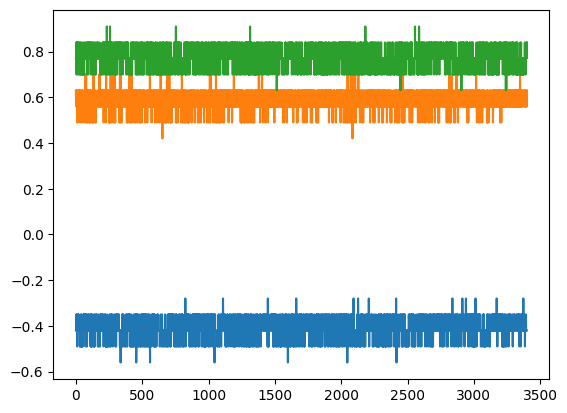

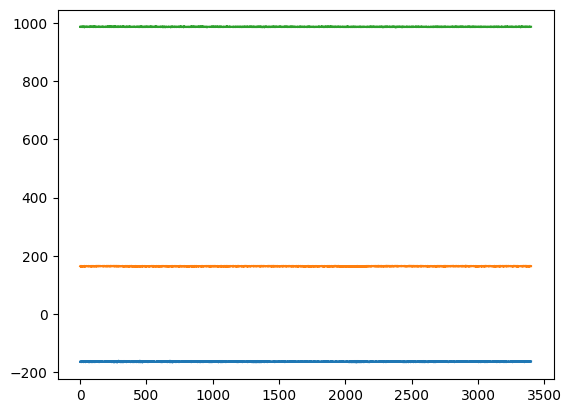

In [89]:
# Convert to rad/s
gyro = gyro_dps * (DEG_TO_RAD)
# convert to m/s^2
accel = accel_mg * MG_TO_MS2


# is_correct = validate_wds_transform(accel)

plt.plot(gyro_dps)
plt.show()
plt.plot(accel_mg)
plt.show()

# Tools

In [90]:
def detect_changes(euler, az_thresh=5.0, alt_thresh=5.0,
                   T_detection=2.0, T_validation=600.0, fs=104.0):
    """
    Detect abrupt orientation changes above thresholds and validate persistence.
    """ 
    az_thresh_rad = np.deg2rad(az_thresh)
    alt_thresh_rad = np.deg2rad(alt_thresh)

    events = []
    baseline = euler[0]
    state = "idle"
    start_idx = None

    for i, angles in enumerate(euler):
        d_az = np.abs(angles[0] - baseline[0])
        d_alt = np.abs(angles[1] - baseline[1])

        if state == "idle":
            if (d_az > az_thresh_rad) or (d_alt > alt_thresh_rad):
                start_idx = i
                state = "detection"

        elif state == "detection":
            if (i - start_idx) >= T_detection * fs:
                # Confirm detection
                events.append({"start_idx": start_idx,
                               "end_idx": i,
                               "angle_change": (d_az, d_alt),
                               "confirmed": False})
                state = "validation"
                validation_start = i

        elif state == "validation":
            if (i - validation_start) >= T_validation * fs:
                events[-1]["confirmed"] = True
                baseline = angles  # new stable baseline
                state = "idle"

    return events

In [91]:
def plot_sensor_data_analysis(accel_mg, gyro_dps, accel_filt=None, gyro_filt=None, fs=104.0, title="Method"):
    """Plot raw vs filtered sensor data for analysis"""
    t = np.arange(len(accel_mg)) / fs
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Raw accelerometer
    axes[0,0].plot(t, accel_mg[:, 0], 'r-', alpha=0.7, label='X')
    axes[0,0].plot(t, accel_mg[:, 1], 'g-', alpha=0.7, label='Y') 
    axes[0,0].plot(t, accel_mg[:, 2], 'b-', alpha=0.7, label='Z')
    axes[0,0].set_title('Raw Accelerometer [mg]')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Raw gyroscope
    axes[0,1].plot(t, gyro_dps[:, 0], 'r-', alpha=0.7, label='X')
    axes[0,1].plot(t, gyro_dps[:, 1], 'g-', alpha=0.7, label='Y')
    axes[0,1].plot(t, gyro_dps[:, 2], 'b-', alpha=0.7, label='Z')
    axes[0,1].set_title('Raw Gyroscope [dps]')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    if accel_filt is not None and gyro_filt is not None:
        # Filtered accelerometer
        axes[1,0].plot(t, accel_filt[:, 0] / MG_TO_MS2, 'r-', alpha=0.7, label='X')
        axes[1,0].plot(t, accel_filt[:, 1] / MG_TO_MS2, 'g-', alpha=0.7, label='Y')
        axes[1,0].plot(t, accel_filt[:, 2] / MG_TO_MS2, 'b-', alpha=0.7, label='Z')
        axes[1,0].set_title('Filtered Accelerometer [mg]')
        axes[1,0].legend()
        axes[1,0].grid(True)
        
        # Filtered gyroscope
        axes[1,1].plot(t, gyro_filt[:, 0] * RAD_TO_DEG, 'r-', alpha=0.7, label='X')
        axes[1,1].plot(t, gyro_filt[:, 1] * RAD_TO_DEG, 'g-', alpha=0.7, label='Y')
        axes[1,1].plot(t, gyro_filt[:, 2] * RAD_TO_DEG, 'b-', alpha=0.7, label='Z')
        axes[1,1].set_title('Filtered Gyroscope [dps]')
        axes[1,1].legend()
        axes[1,1].grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Preprocessing filters

In [92]:
from scipy.signal import butter, filtfilt
def preprocess_imu(accel, gyro, fs=104.0, cutoff=5.0, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='low')
    accel_filt = filtfilt(b, a, accel, axis=0)
    gyro_filt = filtfilt(b, a, gyro, axis=0)
    return accel_filt, gyro_filt

def gyro_bias_removal(gyro, n_seconds=2):
    N = len(gyro)
    n_samples = int(FS * n_seconds)
    n_bias = min(n_samples, N // 4)
    gyro_bias = np.mean(gyro[:n_bias], axis=0)
    gyro_corrected = gyro - gyro_bias
    return gyro_corrected

# Attitude filters

In [93]:
def simple_estimator(accel, gyro, fs):
    N = len(accel)
    euler = np.zeros((N, 3))
    dt = 1/fs

    accel_norm = accel[0] / np.linalg.norm(accel[0])
    # Roll: rotation around X-axis
    euler[0, 2] = np.arctan2(accel_norm[1], accel_norm[2])  # roll
    # Pitch: rotation around Y-axis  
    euler[0, 1] = np.arctan2(-accel_norm[0], np.sqrt(accel_norm[1]**2 + accel_norm[2]**2))  # pitch
    # Yaw: cannot be determined from accelerometer alone
    euler[0, 0] = 0.0  # yaw

    for i in range(1, N):
        # Direct integration of angular velocities
        # gyro[i] is [wx, wy, wz] in body frame
        # For small angles, we can approximate: 
        # euler[i] = euler[i-1] + gyro[i] * dt
        euler[i, 0] = euler[i-1, 0] + gyro[i, 2] * dt  # yaw += wz * dt
        euler[i, 1] = euler[i-1, 1] + gyro[i, 1] * dt  # pitch += wy * dt  
        euler[i, 2] = euler[i-1, 2] + gyro[i, 0] * dt  # roll += wx * dt
    return euler


In [94]:
def estimate_orientation(accel, gyro, method="complementary", fs=104.0):
    from ahrs.common.orientation import q2euler
    from ahrs.common import Quaternion
    from ahrs.filters import Complementary, Madgwick, Mahony, UKF

    N = len(accel)
    euler = np.zeros((N, 3))

    if method == "complementary":
        filt = Complementary(acc=accel, gyr=gyro, frequency=fs, gain=0.01)
        for idx, q in enumerate(filt.Q):
            euler[idx] = q2euler(q)

    elif method == "ukf":
        filt = UKF()
        Q = np.tile([1., 0., 0., 0.], (N, 1))
        for t in range(1, N):
            Q[t] = filt.update(Q[t-1], gyr=gyro[t], acc=accel[t])
            euler[t] = q2euler(Q[t])
    elif method == "simple":
        euler = simple_estimator(accel,gyro,fs)
    else:
        if method == "madgwick":
            filt = Madgwick(gain_imu=0.01)
        elif method == "mahony":
            filt = Mahony(k_P=1.0, k_I=0.1)
        else:
            raise ValueError(f"Unknown method {method}")

        Q = np.tile([1., 0., 0., 0.], (N, 1))
        for t in range(1, N):
            Q[t] = filt.updateIMU(Q[t-1], gyr=gyro[t], acc=accel[t])
            euler[t] = q2euler(Q[t])

    return euler

In [95]:
def plot_orientation_comparison(results, labels=None, ground_truth=None, fs=104.0, title="(un)filtered"):
    import matplotlib.pyplot as plt
    import numpy as np

    if labels is None:
        labels = [f"Method {i}" for i in range(len(results))]

    t = np.arange(results[0].shape[0]) / fs
    titles = ["Yaw (azimuth)", "Pitch (altitude)", "Roll"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for j in range(3):
        for res, lbl in zip(results, labels):
            axs[j].plot(t, np.rad2deg(res[:, j]), label=lbl, alpha=0.8)
        if ground_truth is not None:
            axs[j].plot(t, np.rad2deg(ground_truth[:, j]),
                        label="Ground Truth", linestyle="--", color="k")
        axs[j].set_ylabel(f"{titles[j]} [deg]")
        axs[j].legend(loc="best")
        axs[j].grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle(f"Orientation Comparison Across Filters - {title}")
    plt.show()


UNFILTERED DATA
Processing with simple filter...
Detected 1 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


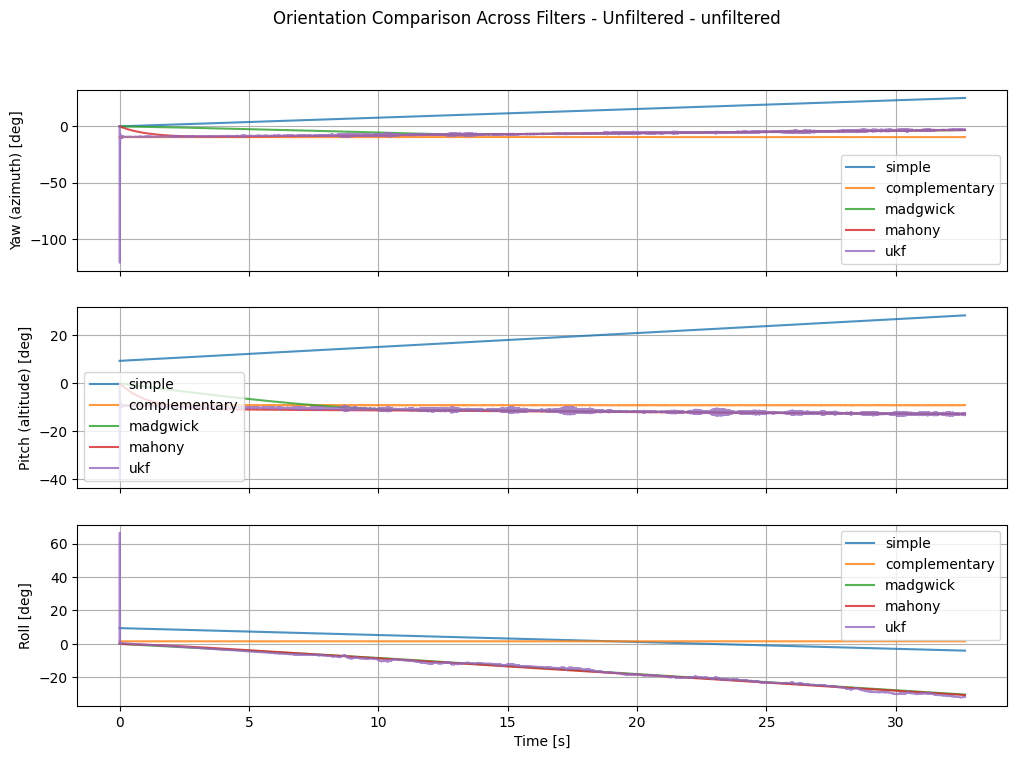

FILTERED DATA
Processing with simple filter...
Detected 0 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


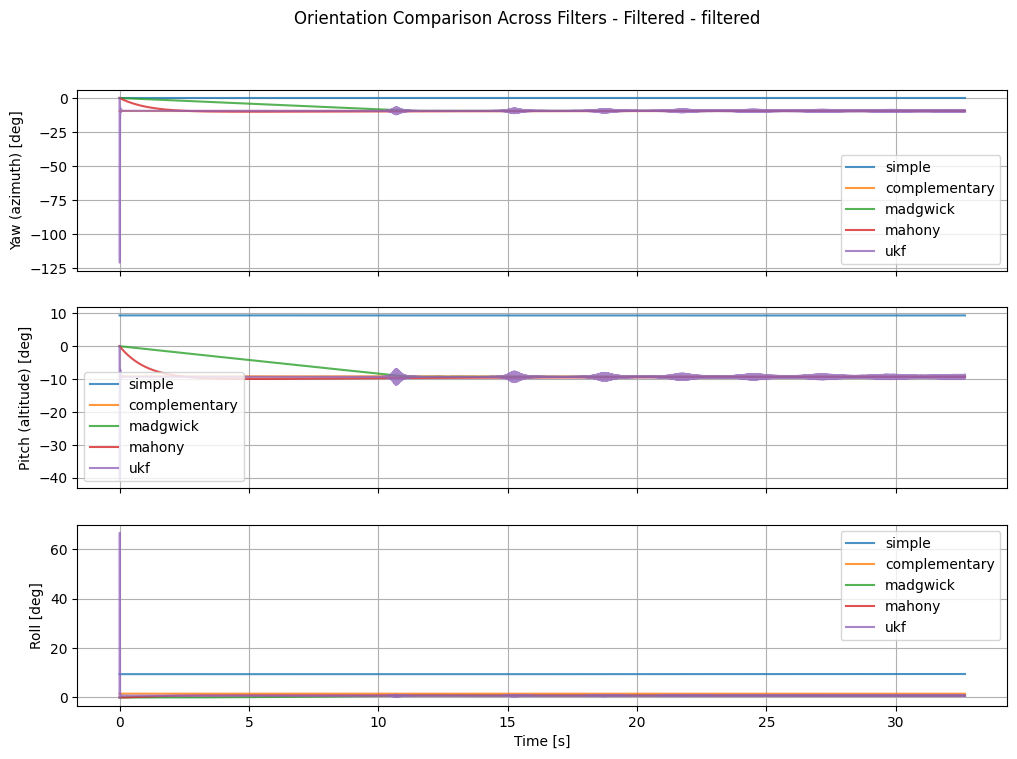

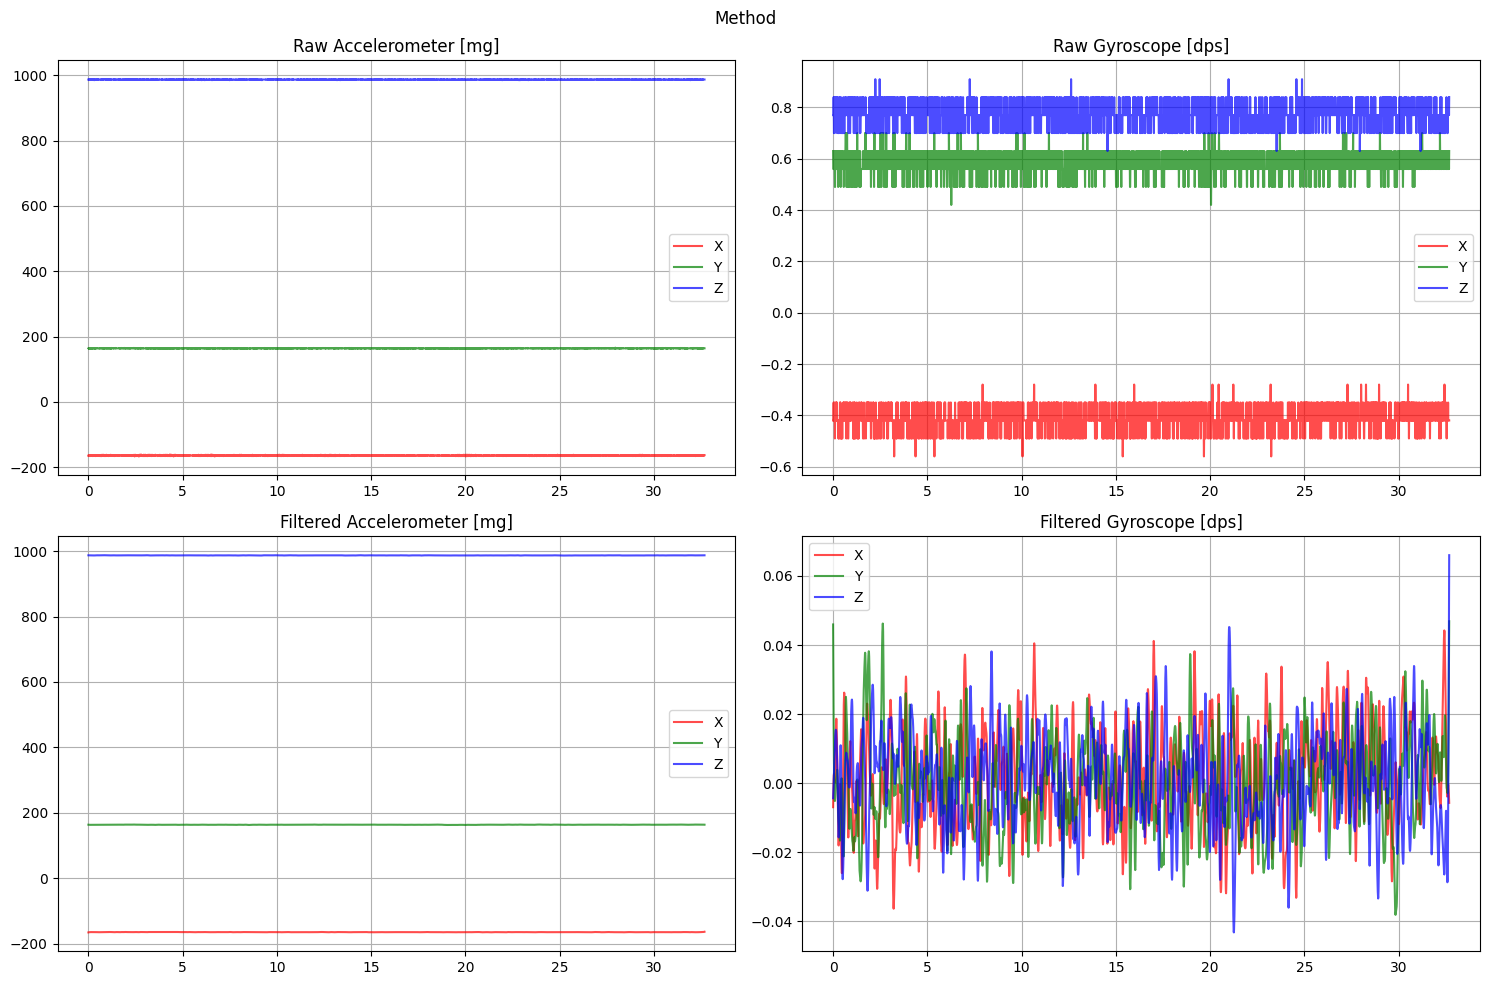

In [96]:
def unfiltered_results(accel, gyro, az_thresh=10, alt_thresh=5, t_detection=2.0, t_validation=600.0, title="unfiltered"):
    results = {}
    title = f"Unfiltered - {title}"

    # Unfiltered
    print("UNFILTERED DATA")
    for method in FILTERS:
        print(f"Processing with {method} filter...")
        euler = estimate_orientation(accel, gyro, method=method, fs=FS)
        events = detect_changes(euler, az_thresh=az_thresh, alt_thresh=alt_thresh,
                                T_detection=t_detection, T_validation=t_validation, fs=FS)
        results[method] = {
            "euler": euler,
            "events": events
        }
        print(f"Detected {len(events)} events with {method} filter.")

    euler_list = [results[method]["euler"] for method in FILTERS]
    plot_orientation_comparison(
        euler_list,
        labels=FILTERS,
        title=title
    )
    return results
def filtered_results(accel, gyro, az_thresh=10, alt_thresh=5, t_detection=2.0, t_validation=600.0, title="filtered"):
    results = {}

    title = f"Filtered - {title}"
    # Filtered
    print("FILTERED DATA")
    for method in FILTERS:
        print(f"Processing with {method} filter...")

        gyro_no_bias = gyro_bias_removal(gyro)
        accel_filt, gyro_filt = preprocess_imu(accel, gyro_no_bias, fs=FS)

        euler = estimate_orientation(accel_filt, gyro_filt, method=method, fs=FS)
        events = detect_changes(euler, az_thresh=az_thresh, alt_thresh=alt_thresh,
                                T_detection=t_detection, T_validation=t_validation, fs=FS)
        results[method] = {
            "euler": euler,
            "events": events,
            "accel_filt": accel_filt,
            "gyro_filt": gyro_filt
        }
        print(f"Detected {len(events)} events with {method} filter.")

    euler_list = [results[method]["euler"] for method in FILTERS]
    plot_orientation_comparison(
        euler_list,
        labels=FILTERS,
        title=title
    )
    return results
results = unfiltered_results(accel,gyro)
results2 = filtered_results(accel,gyro)

method = "complementary"
accel_filt = results2[method]['accel_filt']
gyro_filt = results2[method]['gyro_filt']

plot_sensor_data_analysis(accel_mg, gyro_dps, accel_filt, gyro_filt)

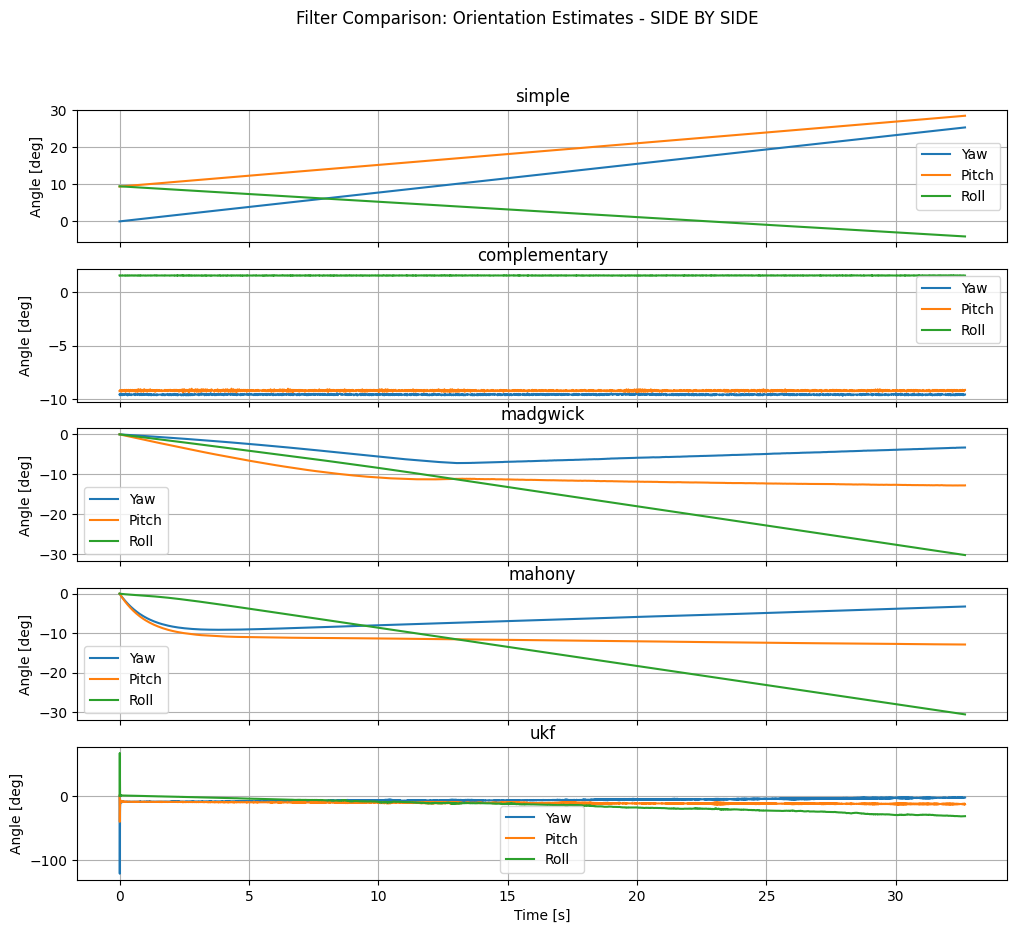

In [97]:
def plot_side_by_side(results, labels, fs=104.0, title="SIDE BY SIDE"):
    """
    Compare filters in separate subplots for easier visual inspection.
    """
    t = np.arange(results[0].shape[0]) / fs

    if len(results) == 1:
        res = results[0]
        lbl = labels[0]
        plt.plot(t, np.rad2deg(res[:,0]), label="Yaw")
        plt.plot(t, np.rad2deg(res[:,1]), label="Pitch")
        plt.plot(t, np.rad2deg(res[:,2]), label="Roll")
        plt.ylabel("Angle [deg]")
        plt.title(lbl)
        plt.legend()
        plt.grid(True)
        return

    fig, axs = plt.subplots(len(results), 1, figsize=(12, 2*len(results)), sharex=True)
    for ax, res, lbl in zip(axs, results, labels):
        ax.plot(t, np.rad2deg(res[:,0]), label="Yaw")
        ax.plot(t, np.rad2deg(res[:,1]), label="Pitch")
        ax.plot(t, np.rad2deg(res[:,2]), label="Roll")
        ax.set_ylabel("Angle [deg]")
        ax.set_title(lbl)
        ax.legend()
        ax.grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle(f"Filter Comparison: Orientation Estimates - {title}")
    plt.show()
# print(results)
vector_results = [results[method]["euler"] for method in FILTERS]
plot_side_by_side(vector_results, labels=FILTERS, fs=FS)


# Evaluation

In [98]:
def evaluate_algorithm(events, ground_truth, tolerance=50):
    detected_idxs = [ev["start_idx"] for ev in events if ev["confirmed"]]
    TP = sum(any(abs(d - g) <= tolerance for g in ground_truth) for d in detected_idxs)
    FP = len(detected_idxs) - TP
    FN = len(ground_truth) - TP

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return {"precision": precision, "recall": recall, "f1": f1,
            "TP": TP, "FP": FP, "FN": FN}

In [99]:
def plot_residuals(results, labels, ground_truth, fs=104.0):
    t = np.arange(results[0].shape[0]) / fs
    titles = ["Yaw Error", "Pitch Error", "Roll Error"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for j in range(3):
        for res, lbl in zip(results, labels):
            err = np.rad2deg(res[:, j] - ground_truth[:, j])
            axs[j].plot(t, err, label=lbl, alpha=0.8)
        axs[j].set_ylabel(f"{titles[j]} [deg]")
        axs[j].legend(loc="best")
        axs[j].grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle("Residuals vs Ground Truth")
    plt.show()


In [100]:
def plot_with_events(euler, events, fs=104.0, label="Filter"):
    """
    Plot orientation with detected events highlighted.
    """
    t = np.arange(len(euler)) / fs
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    axs[0].plot(t, np.rad2deg(euler[:,0]), label="Yaw")
    axs[0].plot(t, np.rad2deg(euler[:,1]), label="Pitch")
    for ev in events:
        if ev["confirmed"]:
            axs[0].axvspan(ev["start_idx"]/fs, ev["end_idx"]/fs,
                           color="red", alpha=0.2)
    axs[0].set_ylabel("Angle [deg]")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t, np.rad2deg(euler[:,2]), label="Roll")
    axs[1].set_ylabel("Roll [deg]")
    axs[1].set_xlabel("Time [s]")
    axs[1].grid(True)

    plt.suptitle(f"Orientation with Detected Events ({label})")
    plt.show()


# FOR ALL TESTS:

Sample length: 3400
METHOD: staticmethod
FILTERED DATA
Processing with simple filter...
Detected 0 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


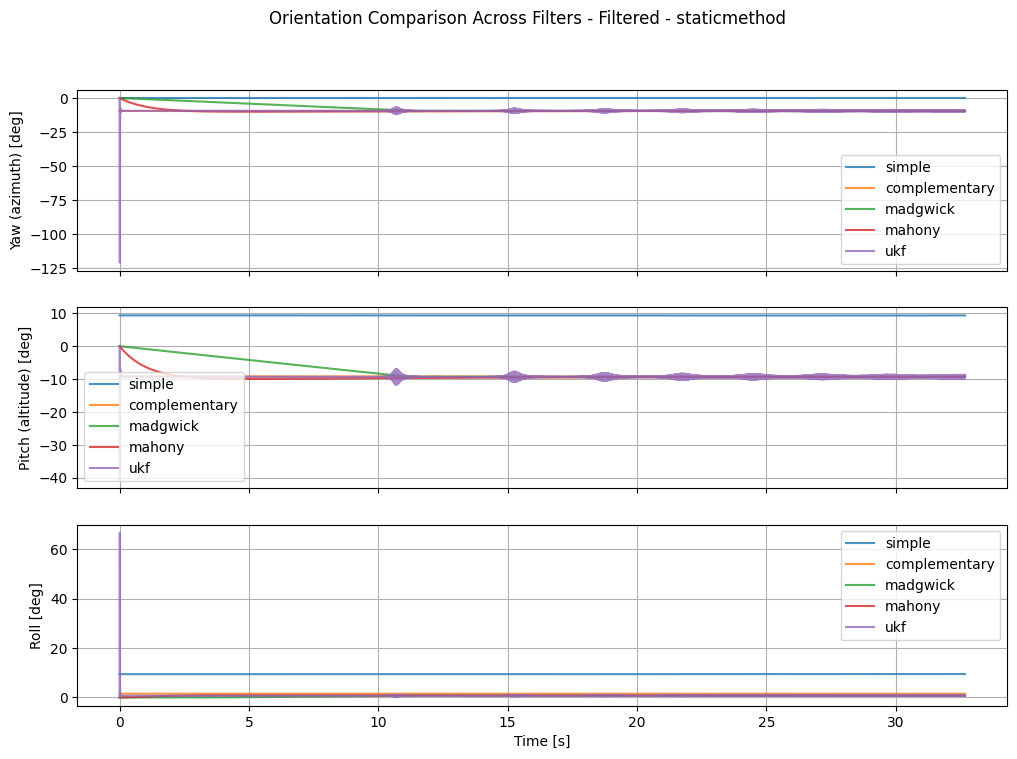

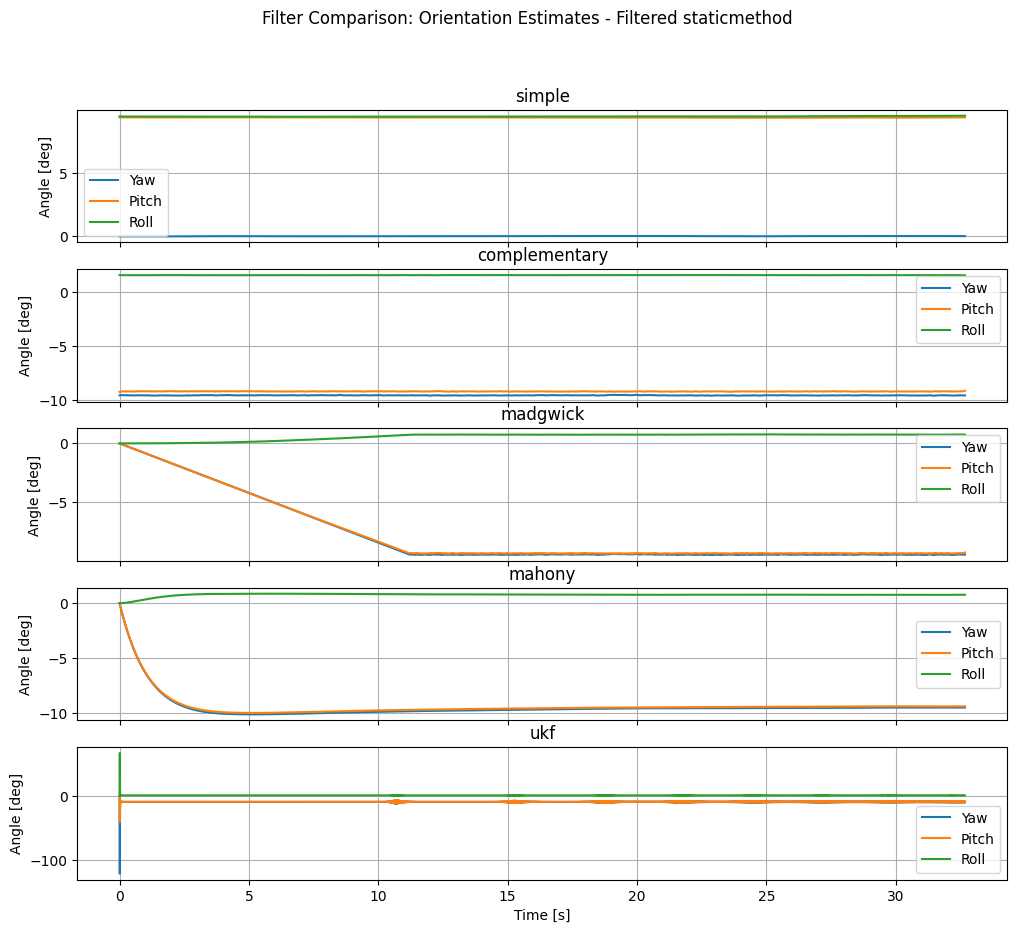

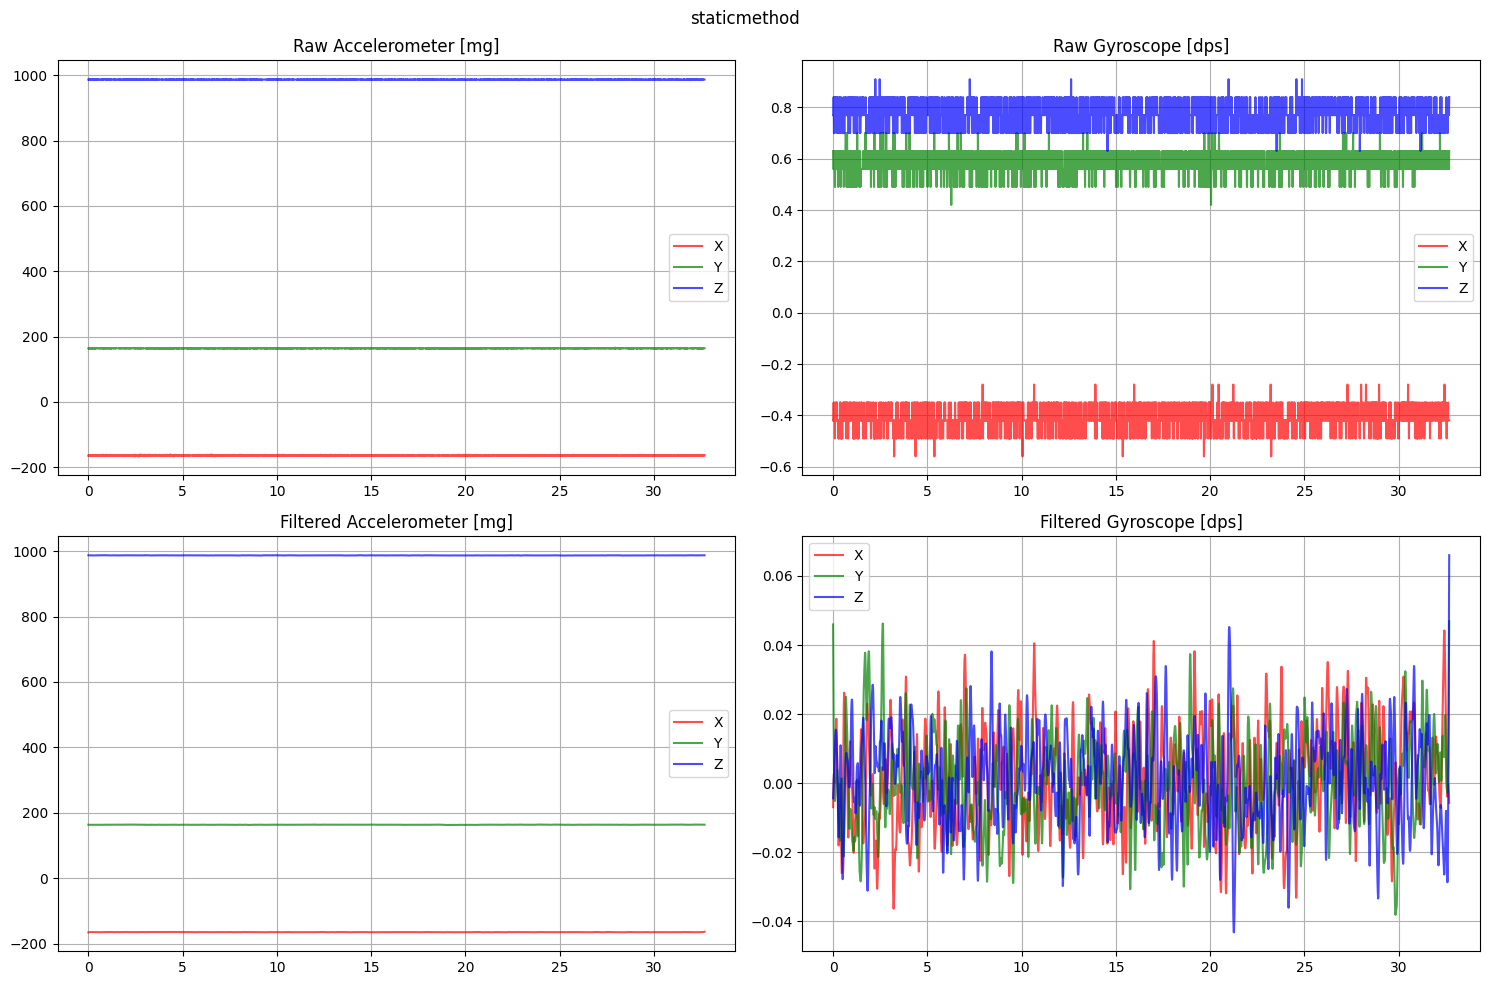

Sample length: 6260
METHOD: altitudemotionmethod al -27
FILTERED DATA
Processing with simple filter...
Detected 0 events with simple filter.
Processing with complementary filter...
Detected 1 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


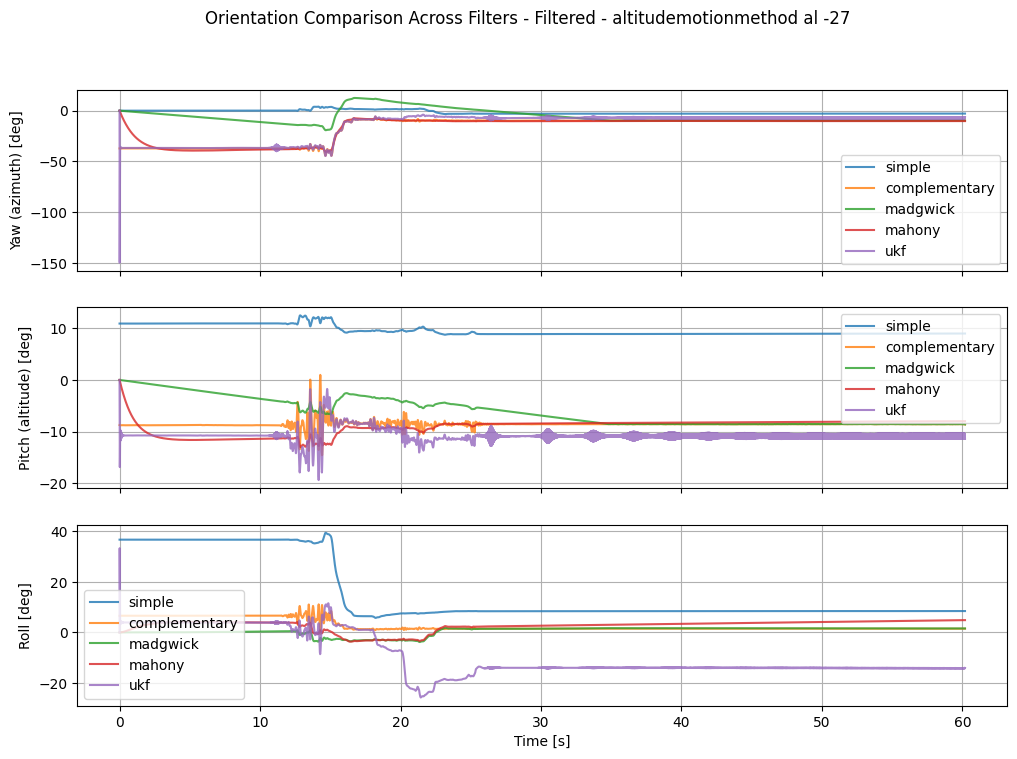

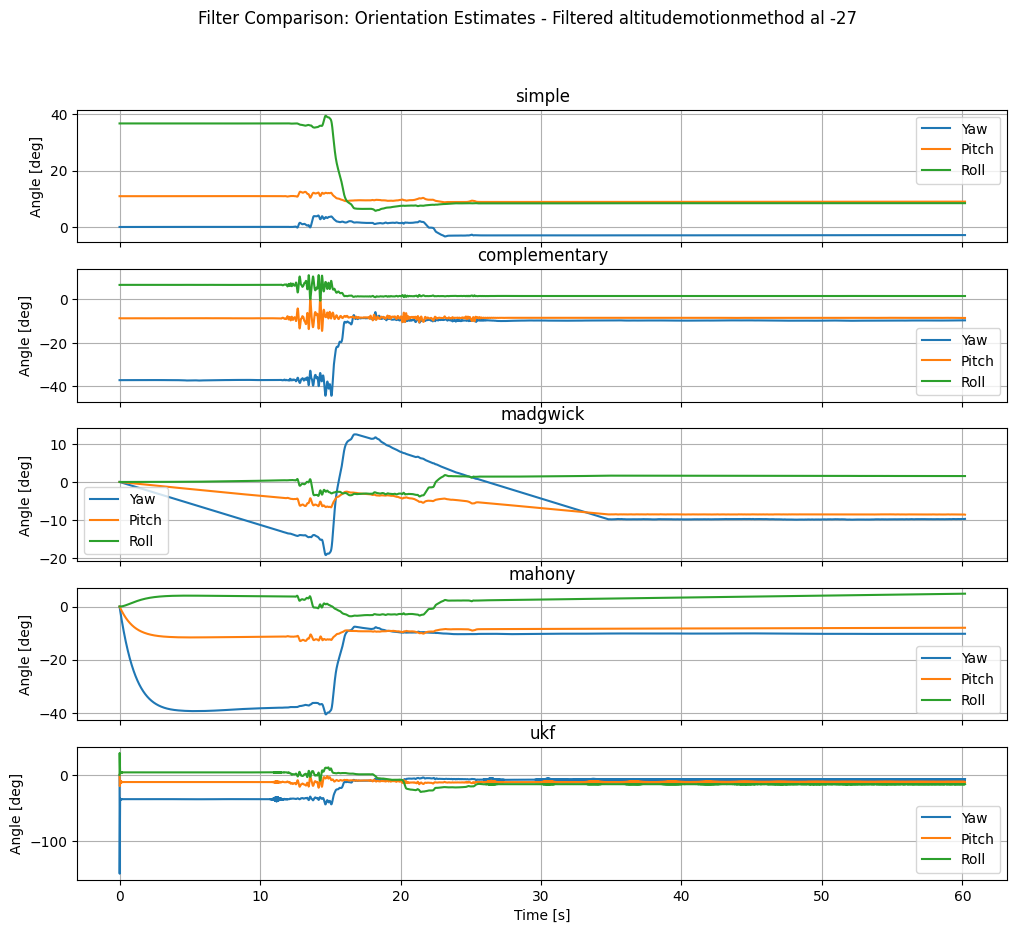

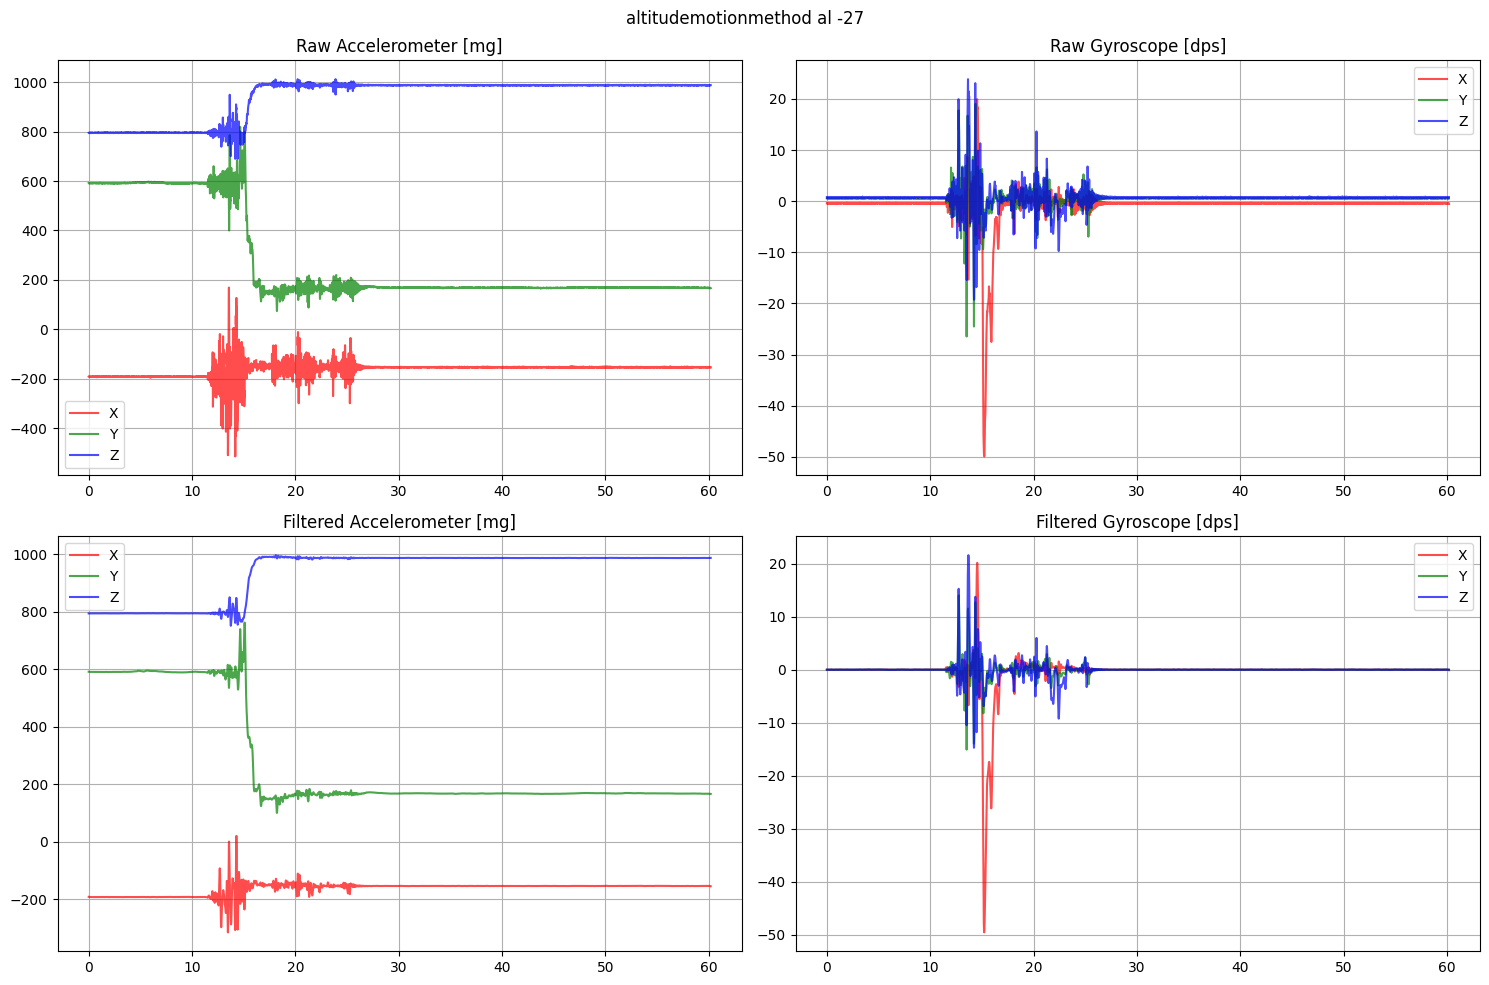

Sample length: 5600
METHOD: altitudemotionmethod al 28
FILTERED DATA
Processing with simple filter...
Detected 0 events with simple filter.
Processing with complementary filter...
Detected 1 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


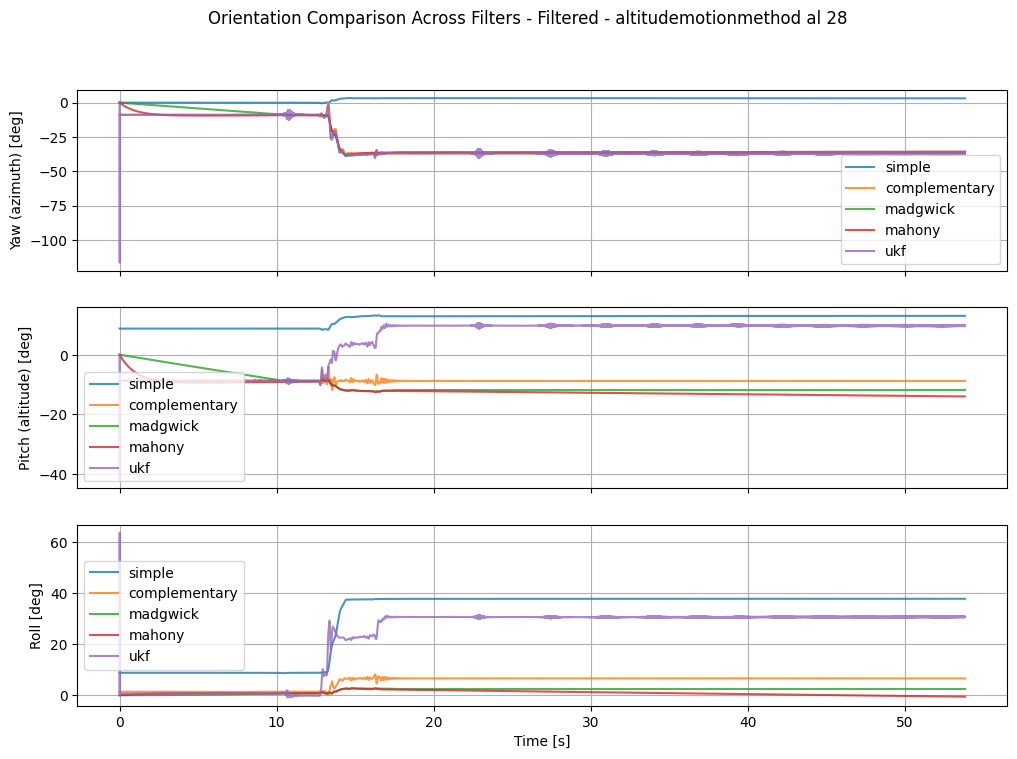

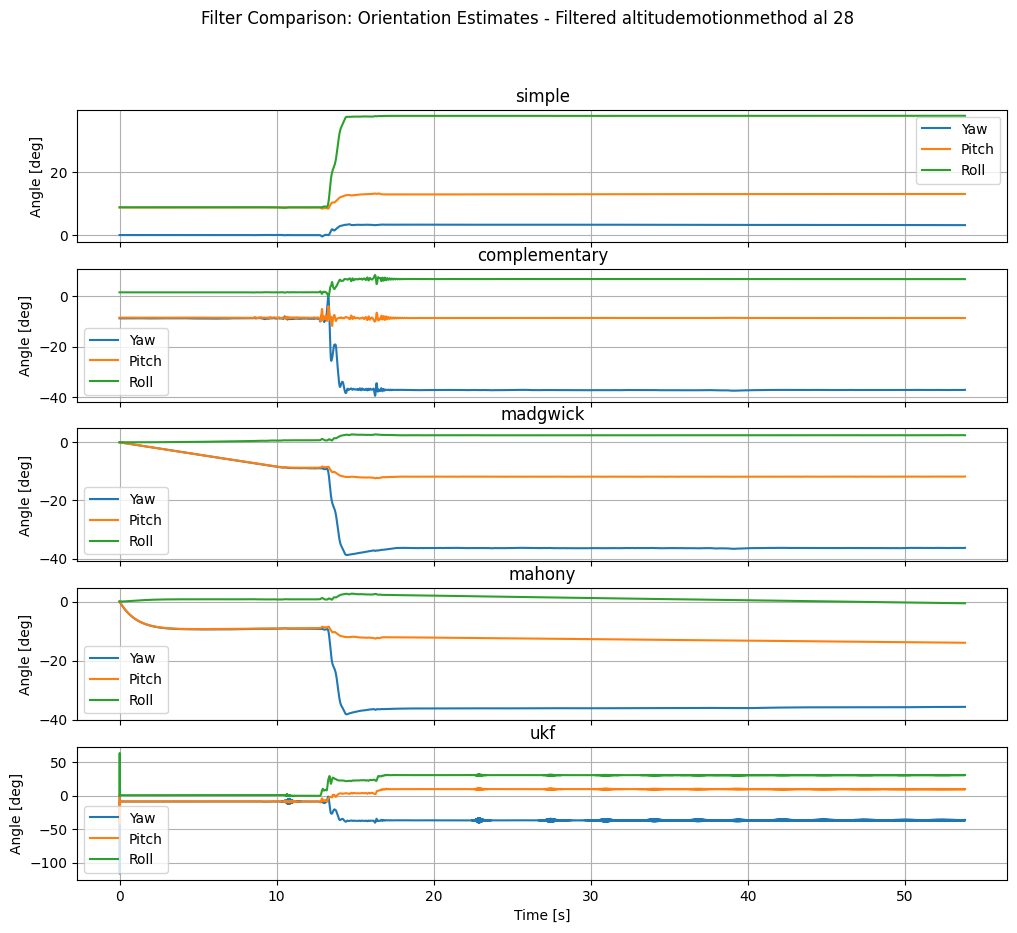

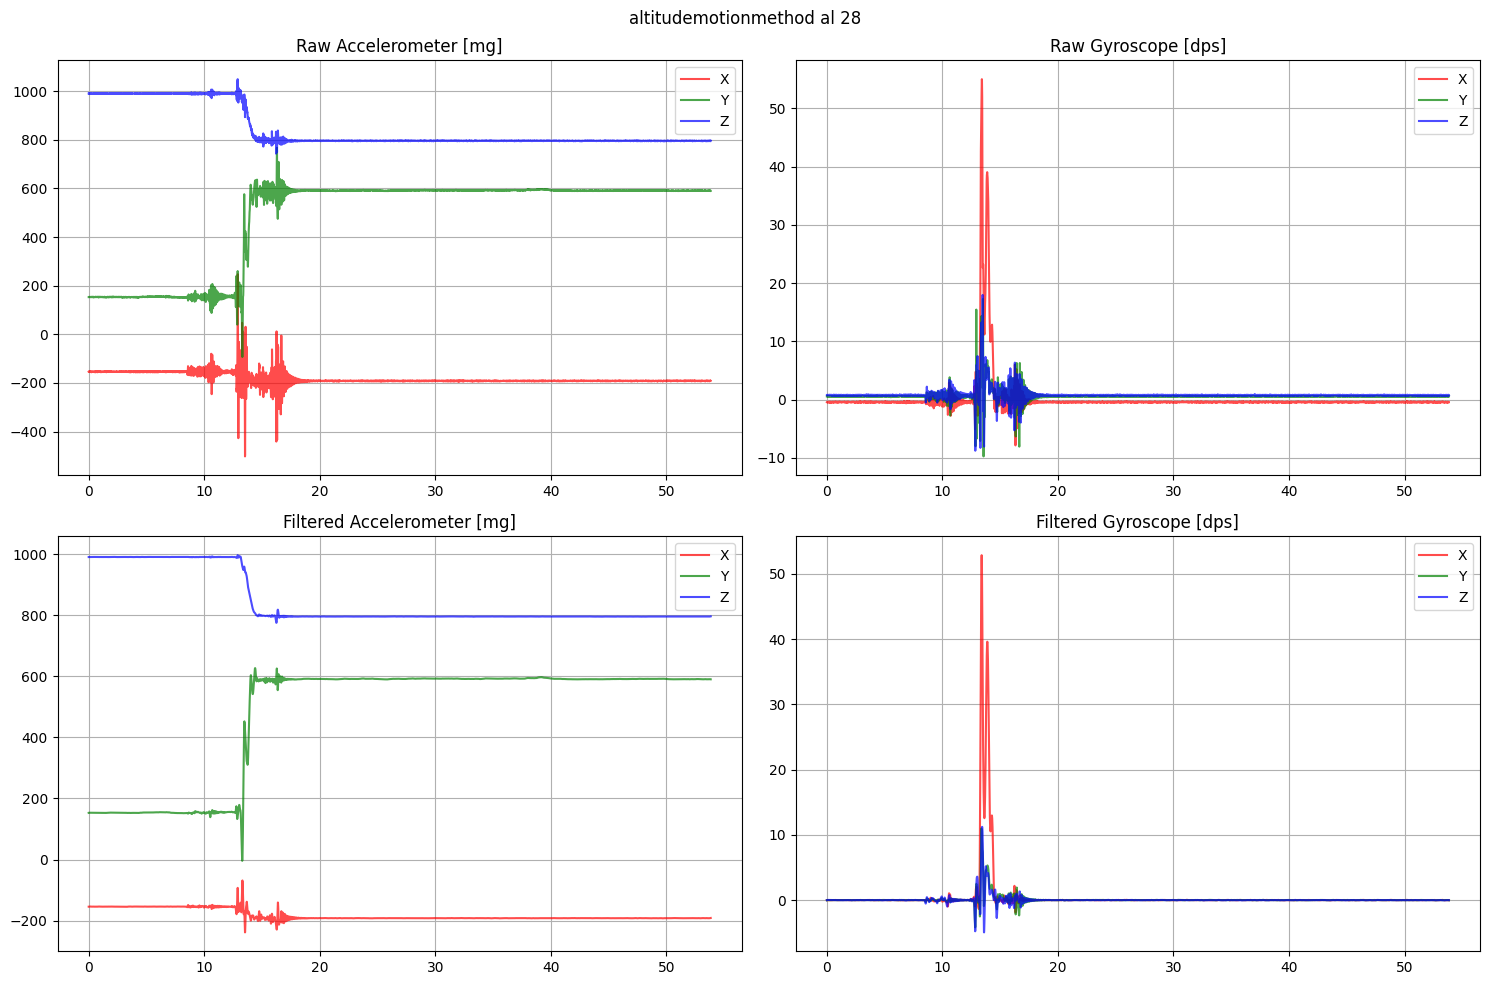

Sample length: 5080
METHOD: azimuthmotionmethod az -15
FILTERED DATA
Processing with simple filter...
Detected 1 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


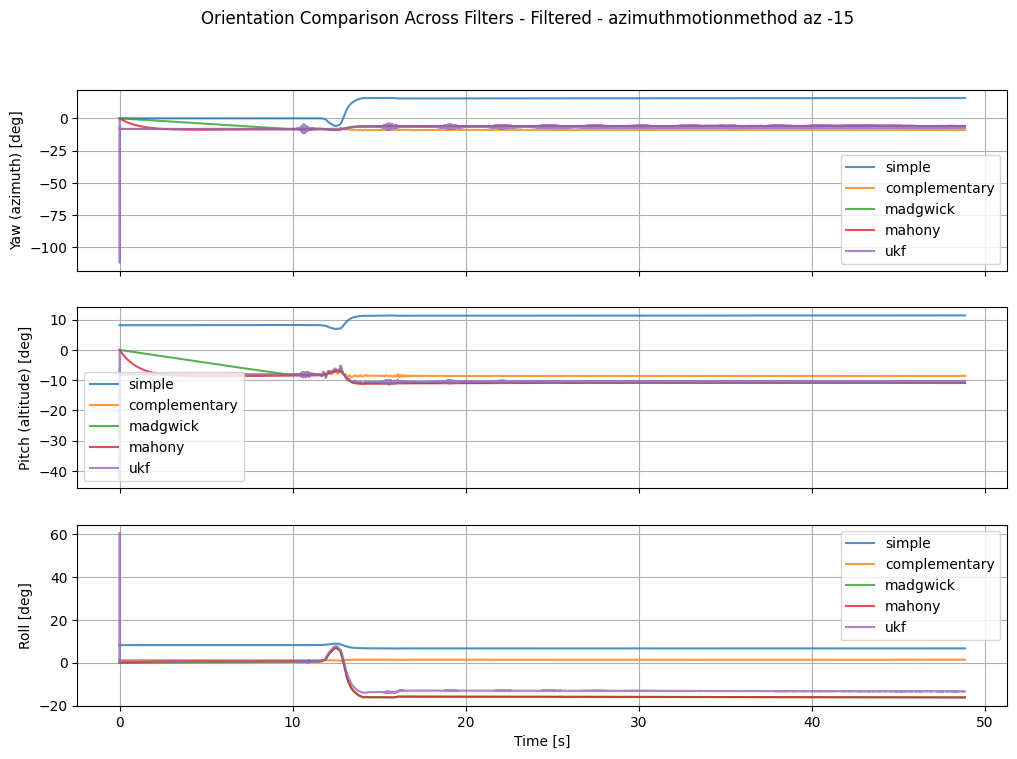

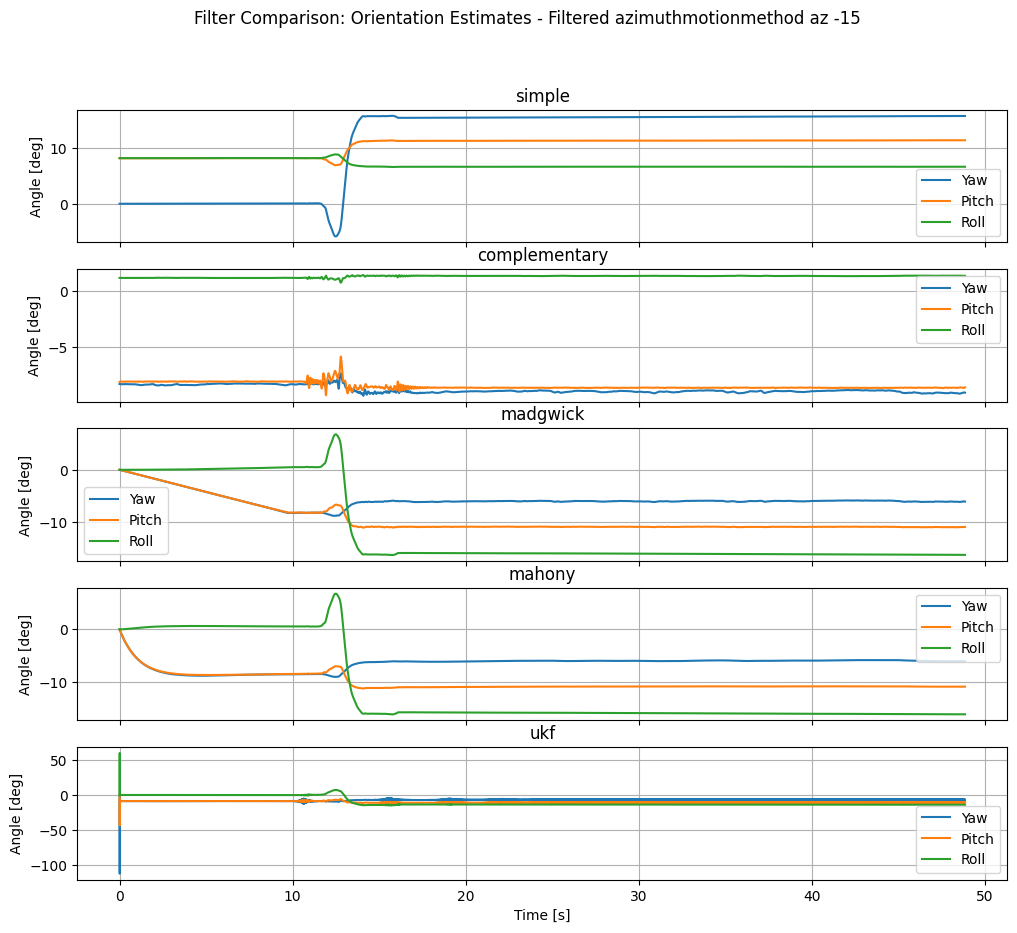

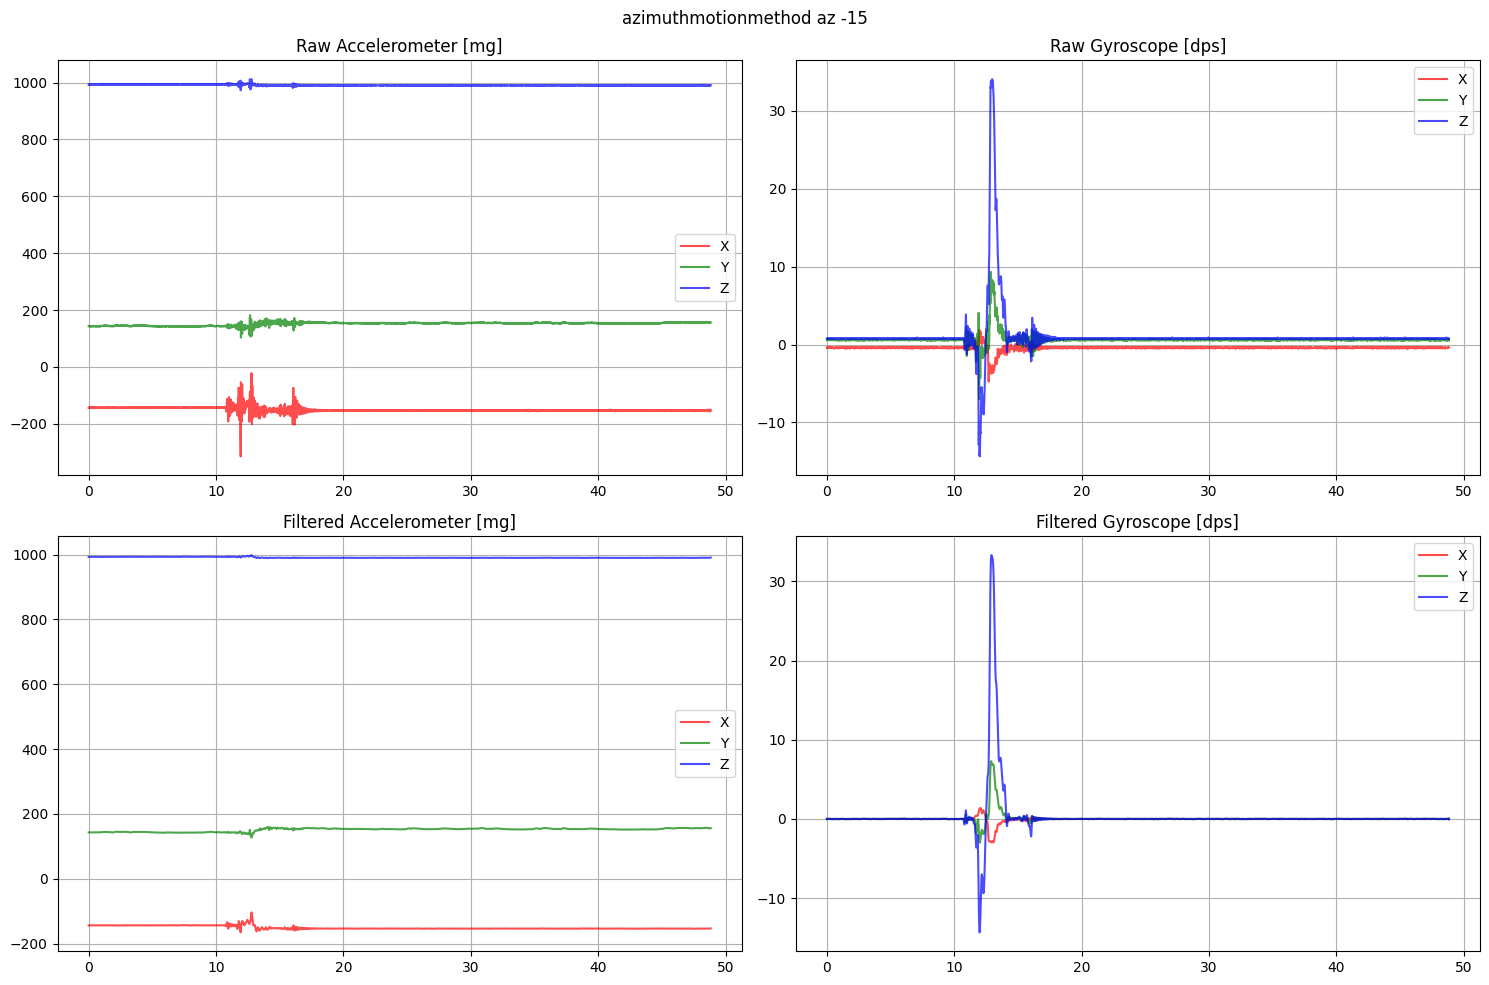

Sample length: 5080
METHOD: azimuthmotionmethod az 30
FILTERED DATA
Processing with simple filter...
Detected 1 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


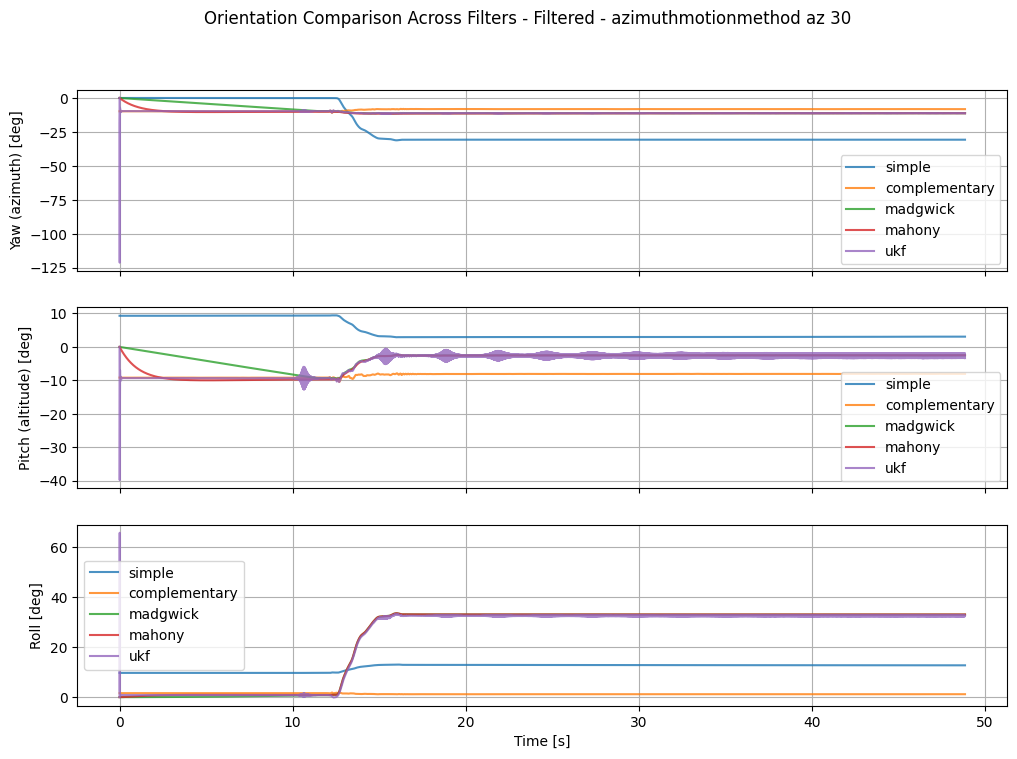

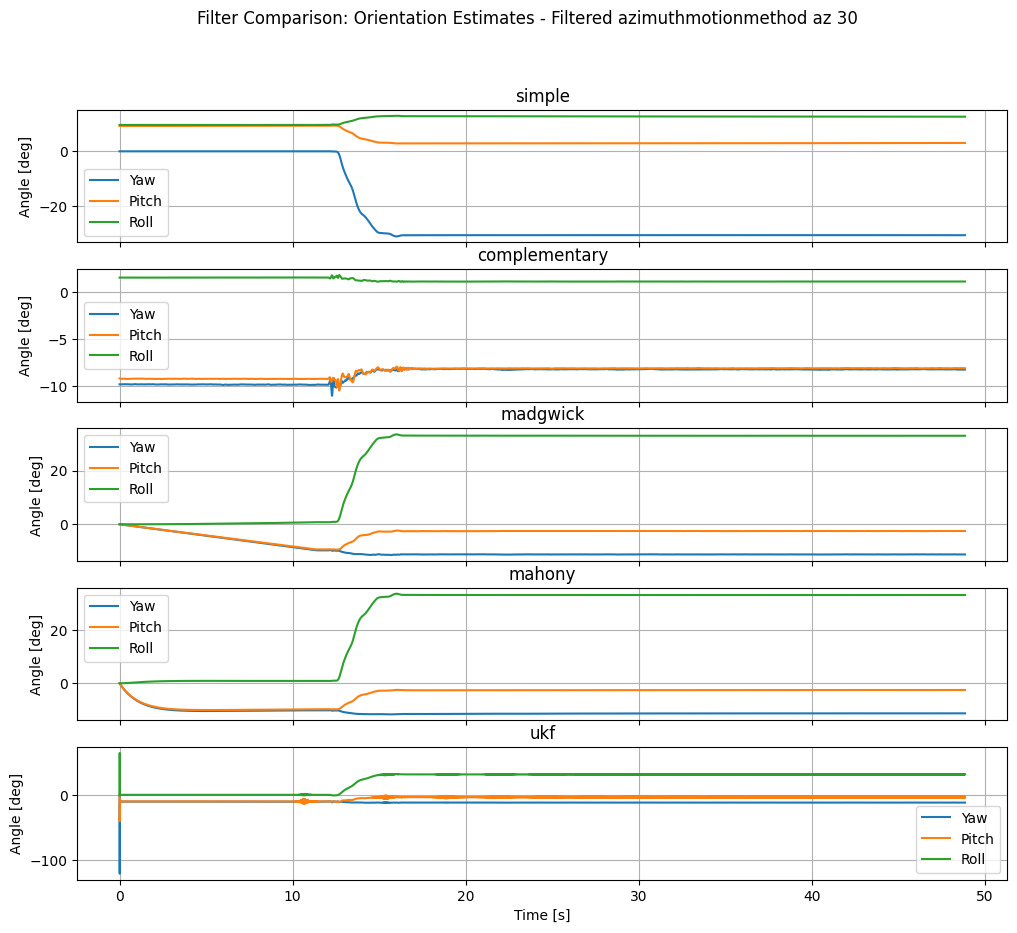

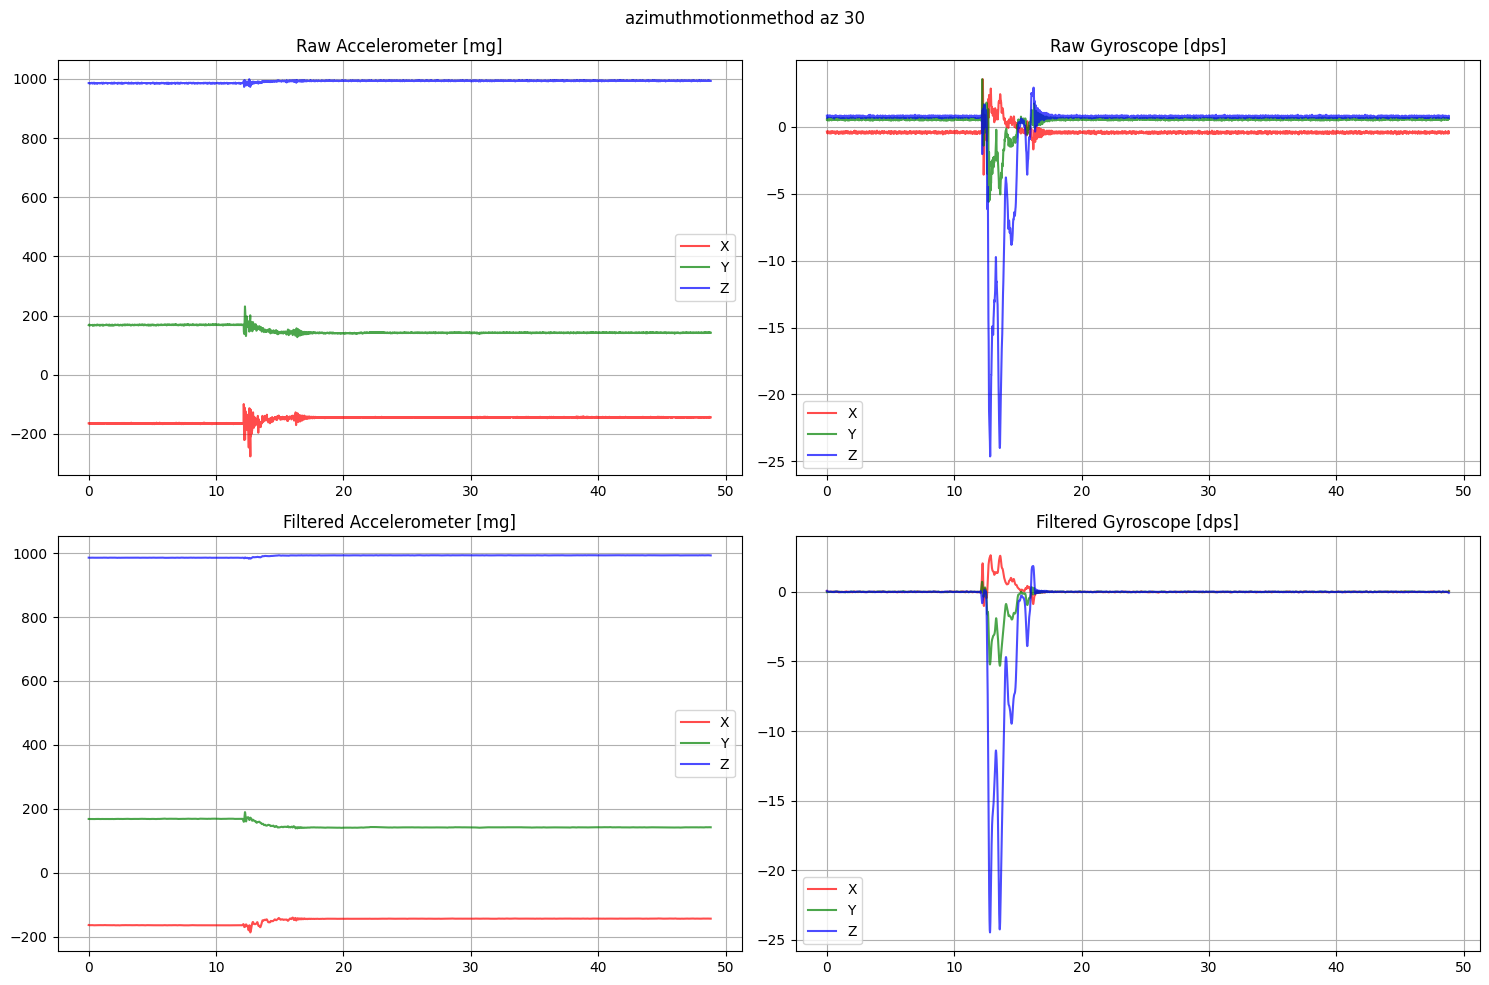

Sample length: 15440
METHOD: vibrationmethod
FILTERED DATA
Processing with simple filter...
Detected 0 events with simple filter.
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 1 events with madgwick filter.
Processing with mahony filter...
Detected 1 events with mahony filter.
Processing with ukf filter...
Detected 1 events with ukf filter.


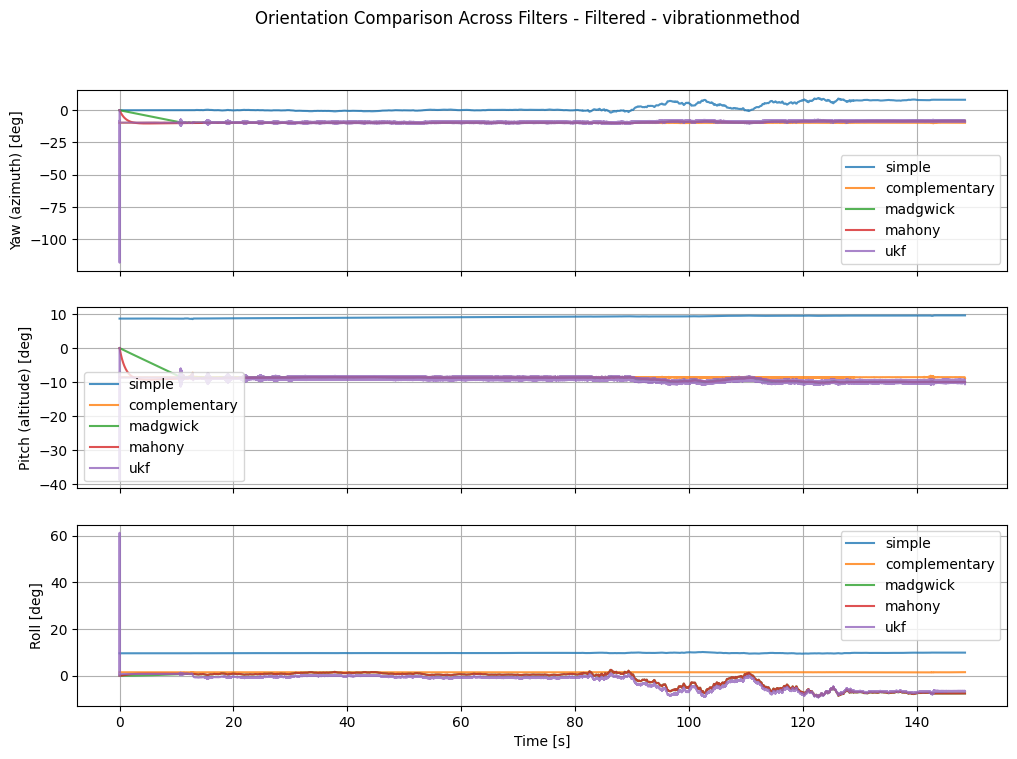

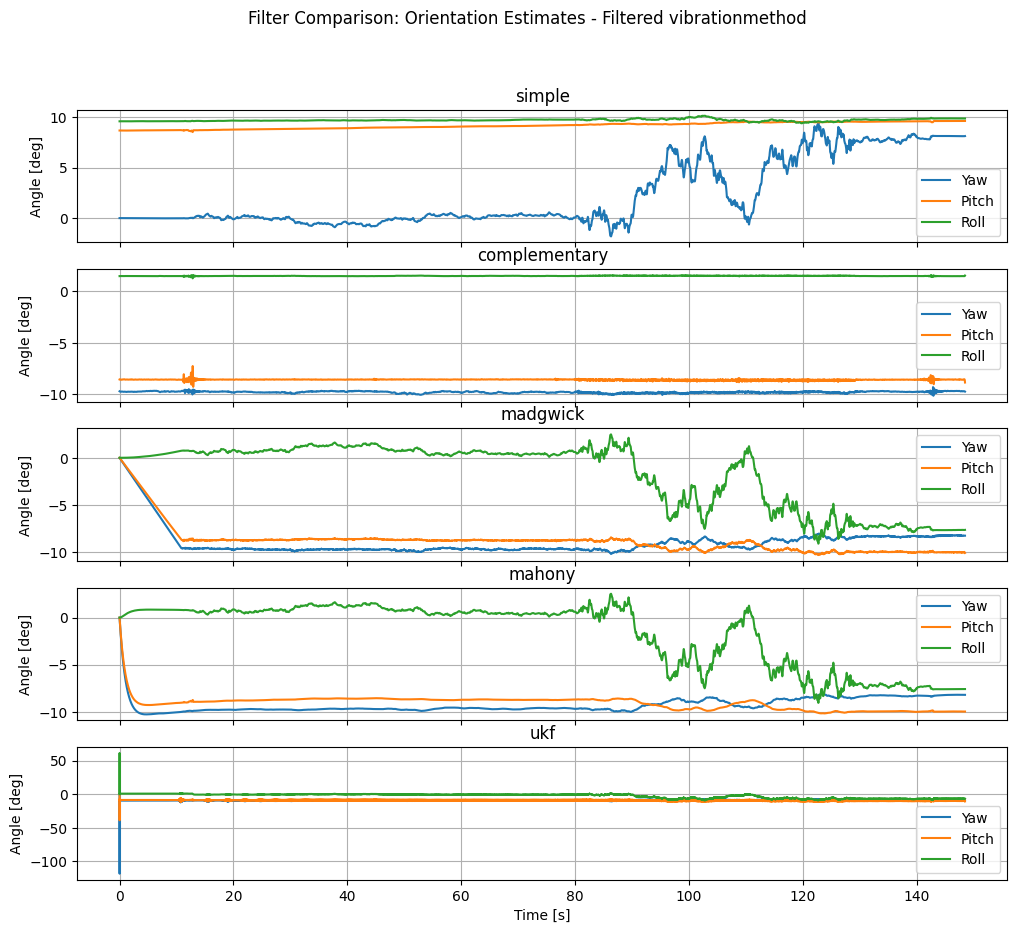

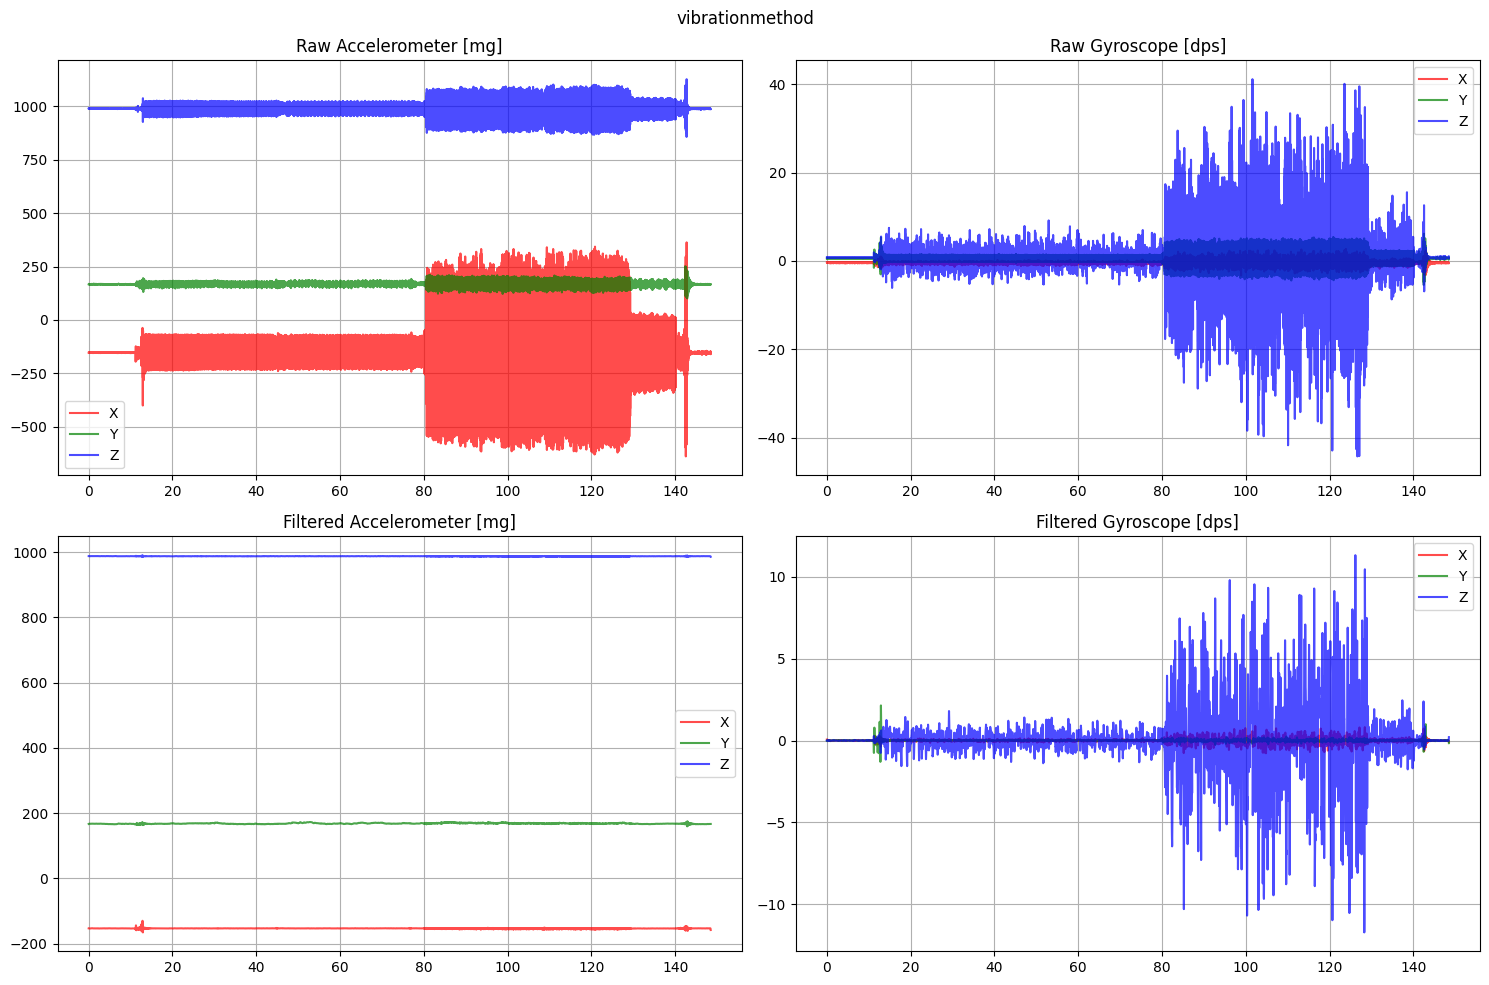

In [102]:
for method, (df, accel_mg, gyro_dps) in datasets.items():
    sample_len = len(df)
    print(f"Sample length: {sample_len}")

    # Convert to rad/s
    gyro = gyro_dps * (DEG_TO_RAD)
    
    # convert to m/s^2
    accel = accel_mg * MG_TO_MS2

    print("METHOD:", method)

    # FILTERS = ["simple"]

    # unfiltered_res = unfiltered_results(accel,gyro,title=method)
    # vector_results = [unfiltered_res[method]["euler"] for method in FILTERS]
    # plot_side_by_side(vector_results, labels=FILTERS, fs=FS, title=f"Unfiltered {method}")
    filtered_res = filtered_results(accel,gyro, title=method)
    accel_filt, gyro_filt = filtered_res[FILTERS[0]]["accel_filt"], filtered_res[FILTERS[0]]["gyro_filt"]
    vector_results = [filtered_res[method]["euler"] for method in FILTERS]
    plot_side_by_side(vector_results, labels=FILTERS, fs=FS, title=f"Filtered {method}")
    plot_sensor_data_analysis(accel_mg, gyro_dps, accel_filt, gyro_filt, title=method)


    
